In [2]:
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')  # ignore DeprecationWarnings from tensorflow

import matplotlib.pyplot as plt
%matplotlib inline

import gpflow

from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter

from multiclass_classification import plot_posterior_predictions, colors

np.random.seed(0)  # reproducibility

In [3]:
# Number of functions and number of data points
C = 3
N = 100

# RBF kernel lengthscale
lengthscale = 0.1

# Jitter
jitter_eye = np.eye(N) * 1e-6

# Input
X = np.random.rand(N, 1)

In [4]:
# SquaredExponential kernel matrix
kernel_se = gpflow.kernels.SquaredExponential(lengthscale=lengthscale)
K = kernel_se(X) + jitter_eye

# Latents prior sample
f = np.random.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T

# Hard max observation
Y = np.argmax(f, 1).reshape(-1,).astype(int)

# One-hot encoding
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y] = 1

data = (X, Y)

In [5]:
x = np.zeros((X.size))
for i, element in enumerate(X):
    x[i] = element

data = (x,Y)
print(data)

(array([0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ,
       0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152,
       0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606,
       0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215,
       0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443,
       0.63992102, 0.14335329, 0.94466892, 0.52184832, 0.41466194,
       0.26455561, 0.77423369, 0.45615033, 0.56843395, 0.0187898 ,
       0.6176355 , 0.61209572, 0.616934  , 0.94374808, 0.6818203 ,
       0.3595079 , 0.43703195, 0.6976312 , 0.06022547, 0.66676672,
       0.67063787, 0.21038256, 0.1289263 , 0.31542835, 0.36371077,
       0.57019677, 0.43860151, 0.98837384, 0.10204481, 0.20887676,
       0.16130952, 0.65310833, 0.2532916 , 0.46631077, 0.24442559,
       0.15896958, 0.11037514, 0.65632959, 0.13818295, 0.19658236,
       0.36872517, 0.82099323, 0.09710128, 0.83794491, 0.09609841,
       0.97645947, 0.4686512 , 0.97676109, 0.60484552, 0.7392

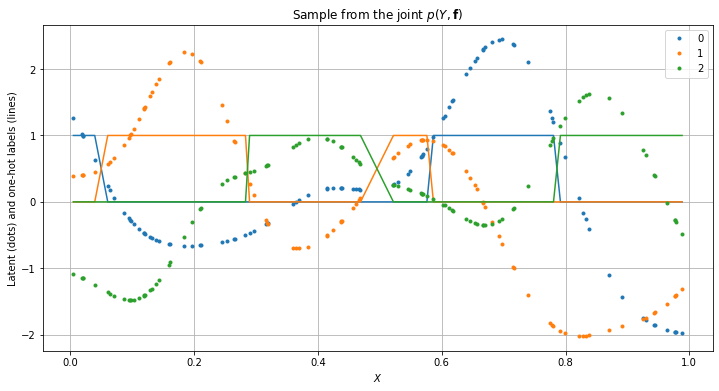

In [6]:
plt.figure(figsize=(12, 6))
order = np.argsort(X.reshape(-1,))

for c in range(C):  
    plt.plot(X[order], f[order, c], '.', color=colors[c], label=str(c))
    plt.plot(X[order], Y_hot[order, c], '-', color=colors[c])


plt.legend()
plt.xlabel('$X$')
plt.ylabel('Latent (dots) and one-hot labels (lines)')
plt.title('Sample from the joint $p(Y, \mathbf{f})$')
plt.grid()
plt.show()

In [7]:
# sum kernel: Matern32 + White
kernel = gpflow.kernels.Matern32() + gpflow.kernels.White(variance=0.01)

# Robustmax Multiclass Likelihood
invlink = gpflow.likelihoods.RobustMax(C)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(3, invlink=invlink)  # Multiclass likelihood
Z = X[::5].copy()  # inducing inputs

m = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood,
    inducing_variable=Z, num_latent=C, whiten=True, q_diag=True)

# Only train the variational parameters
set_trainable(m.kernel.kernels[1].variance, False)
set_trainable(m.inducing_variable, False)
print_summary(m, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,False,(),float64,0.009999999776482648
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,False,(),float64,0.001000000047497451
SVGP.inducing_variable.Z,Parameter,,False,"(20, 1)",float64,[[0.5488135...
SVGP.q_mu,Parameter,,True,"(20, 3)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,Softplus,True,"(20, 3)",float64,"[[1., 1., 1...."


In [9]:
opt = gpflow.optimizers.Scipy()

@tf.function(autograph=False)
def objective_closure():
    return - m.log_marginal_likelihood(data)

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=ci_niter(1000)))
print_summary(m, fmt='notebook')

TypeError: log_likelihood() missing 1 required positional argument: 'Y'